<a href="https://colab.research.google.com/github/AbhinavZ2803/dbms/blob/main/media_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install pycaret


In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

device = torch.device("cuda")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection


Mounted at /content/drive
/content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection


([<matplotlib.patches.Wedge at 0x78ada7ba5c10>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Biased'),
  Text(1.1968726986325005, 0.08657796063754254, 'Unbiased')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

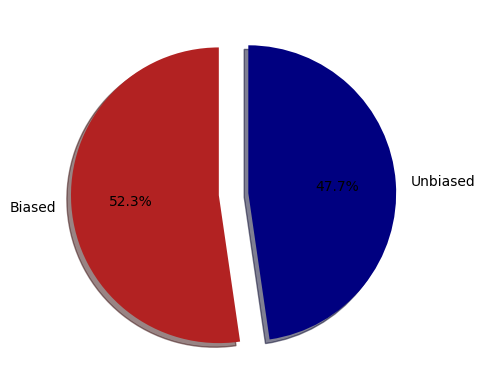

In [ ]:
unbiased_data = pd.read_csv('/content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection/dataset/Unbiased.csv')
biased_data = pd.read_csv('/content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection/dataset/Biased.csv')

unbiased_data['Target'] = ['Unbiased']*len(unbiased_data)
biased_data['Target'] = ['Biased']*len(biased_data)


data = pd.concat([unbiased_data, biased_data]).sample(frac=1).reset_index(drop=True)


data['label'] = pd.get_dummies(data.Target)['Biased']

label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Biased','Unbiased'],autopct='%1.1f%%')

In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Factbox: Issues at stake in Trump-China summit...,(Reuters) - President Donald Trump faces his b...,politicsNews,"April 6, 2017",Unbiased,False
1,Cuba issues bristling editorial ahead of Obama...,HAVANA (Reuters) - Cuba said it would welcome ...,politicsNews,"March 9, 2016",Unbiased,False
2,CNN’s Reza Aslan Just Tore Into Trump’s Bigot...,CNN s Reza Aslan is a world renowned author an...,News,"June 4, 2017",Biased,True
3,HOW MUSLIM IMMIGRANTS HAVE DESTROYED BRITAIN’S...,The result of Britain s willingness to allow M...,politics,"Sep 23, 2015",Biased,True
4,Cruz Brutally Mocks Trump For Trying To Back ...,"Once again, Republican front runner Donald Tru...",News,"March 29, 2016",Biased,True


In [ ]:


train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

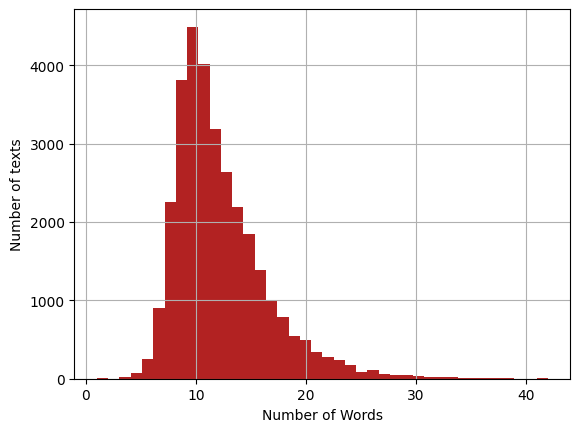

In [ ]:

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:

MAX_LENGHT = 15

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:

for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x
model = BERT_Arch(bert)

from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 1e-5)

cross_entropy  = nn.NLLLoss()

epochs = 10

In [ ]:
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cross_entropy = nn.CrossEntropyLoss()


model.to(device)

def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))


        sent_id, mask, labels = [r.to(device) for r in batch]


        labels = labels.long()


        model.zero_grad()


        preds = model(sent_id, mask)


        loss = cross_entropy(preds, labels)
        total_loss += loss.item()


        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        optimizer.step()


    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss = 0

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))


        sent_id, mask, labels = [t.to(device) for t in batch]


        labels = labels.long()

        with torch.no_grad():

            preds = model(sent_id, mask)


            loss = cross_entropy(preds, labels)
            total_loss += loss.item()


    avg_loss = total_loss / len(val_dataloader)

    return avg_loss


In [ ]:

best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), ' c2_new_model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.562
Validation Loss: 0.494

 Epoch 2 / 10
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.


In [ ]:

path = '/content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection/c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():

  test_seq = test_seq.to(device)
  test_mask = test_mask.to(device)

  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

       False       0.85      0.92      0.88      3212
        True       0.92      0.85      0.89      3523

    accuracy                           0.89      6735
   macro avg       0.89      0.89      0.89      6735
weighted avg       0.89      0.89      0.89      6735



In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",

]


MAX_LENGHT = 15


tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LENGHT,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)


unseen_seq = tokens_unseen['input_ids']
unseen_mask = tokens_unseen['attention_mask']


unseen_seq = unseen_seq.to(device)
unseen_mask = unseen_mask.to(device)


with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis=1)
print("Predictions:", preds)



Predictions: [1 1 0]


In [ ]:
preds


array([1, 1, 0])

In [ ]:

label_map = {0: "true", 1: "false"}


pred_labels = [label_map[pred] for pred in preds]
pred_labels


['false', 'false', 'true']